This notebook contains code to obtain BERT classification results for 7 classes.<br />
The model was trained on Colab, so inline results of the run are omitted and shown as figures.<br />
Use ktrain (https://github.com/amaiya/ktrain) - a lightweight Keras library - to train the model.

In [1]:
import ktrain
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

from ktrain import text
from sklearn.model_selection import train_test_split
from IPython.display import Image

In [2]:
# Define emotion classes.
emotions = ['neutral', 'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

In [3]:
# Get training data.
data = pd.read_csv('../../data/training_data/data_train_7_classes.csv')

In [ ]:
# Data is very skewed, so drop some entries from over populated classes to reduce training time and bias.
data = data.drop(data[data['Emotion'].eq('neutral')].sample(70000).index)
data = data.drop(data[data['Emotion'].eq('happiness')].sample(5000).index)
data.Emotion.value_counts()

In [ ]:
# # Split training data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(data.Text, data.Emotion,
                                                  stratify=data.Emotion, 
                                                  shuffle=True,
                                                  test_size=0.2)
X_train = X_train.tolist()
X_test = X_test.tolist()

In [ ]:
encoding = {
    'neutral': 0,
    'anger': 1,
    'disgust': 2,
    'fear': 3,
    'happiness': 4,
    'sadness': 5,
    'surprise': 6
}

# Encode outputs.
y_train = [encoding[x] for x in y_train]
y_test = [encoding[x] for x in y_test]

In [ ]:
# Preprocess data.
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=emotions_7,
                                                                       preprocess_mode='bert',
                                                                       maxlen=350, 
                                                                       max_features=35000)

In [ ]:
# Initialise BERT model.
model = text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)

In [ ]:
# Prepare model for training.
learner = ktrain.get_learner(model, train_data=(x_train, y_train), 
                             val_data=(x_test, y_test),
                             batch_size=6)

In [ ]:
# To shorten training time, train the model for a set number of epochs on a pre-selected learning rate.
learner.fit_onecycle(2e-5, 3)

In [ ]:
# Display validation results.
# Note: running this cell takes a really long time.
out = learner.validate(val_data=(x_test, y_test), class_names=class_names)

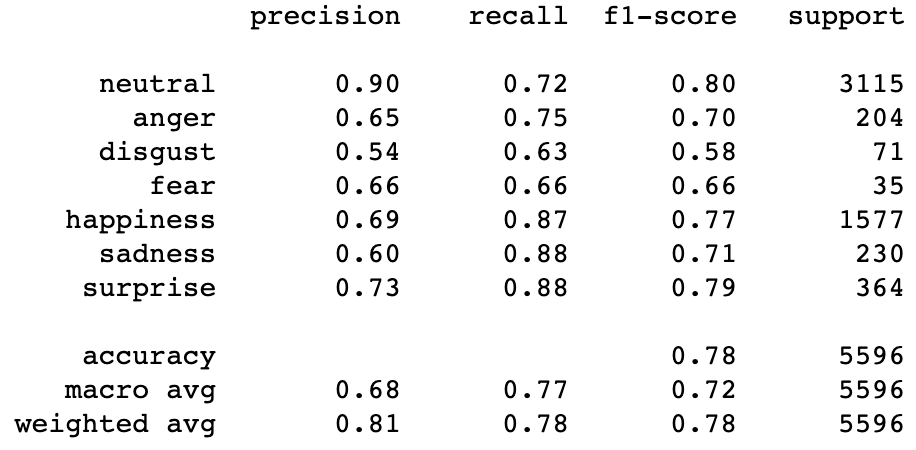

In [5]:
# Display validation results.
# The table was generated by running the above cell in the process of fine-tuning the model.
Image(filename='../../data/BERT_plots/bert_7_validation.png', width = 450, height = 150) 

In [ ]:
# Display confusion matrix.
# Real labels on the left, predicted on the bottom.
df_cm = pd.DataFrame(out, index = [i for i in emotions],
                  columns = [i for i in emotions])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

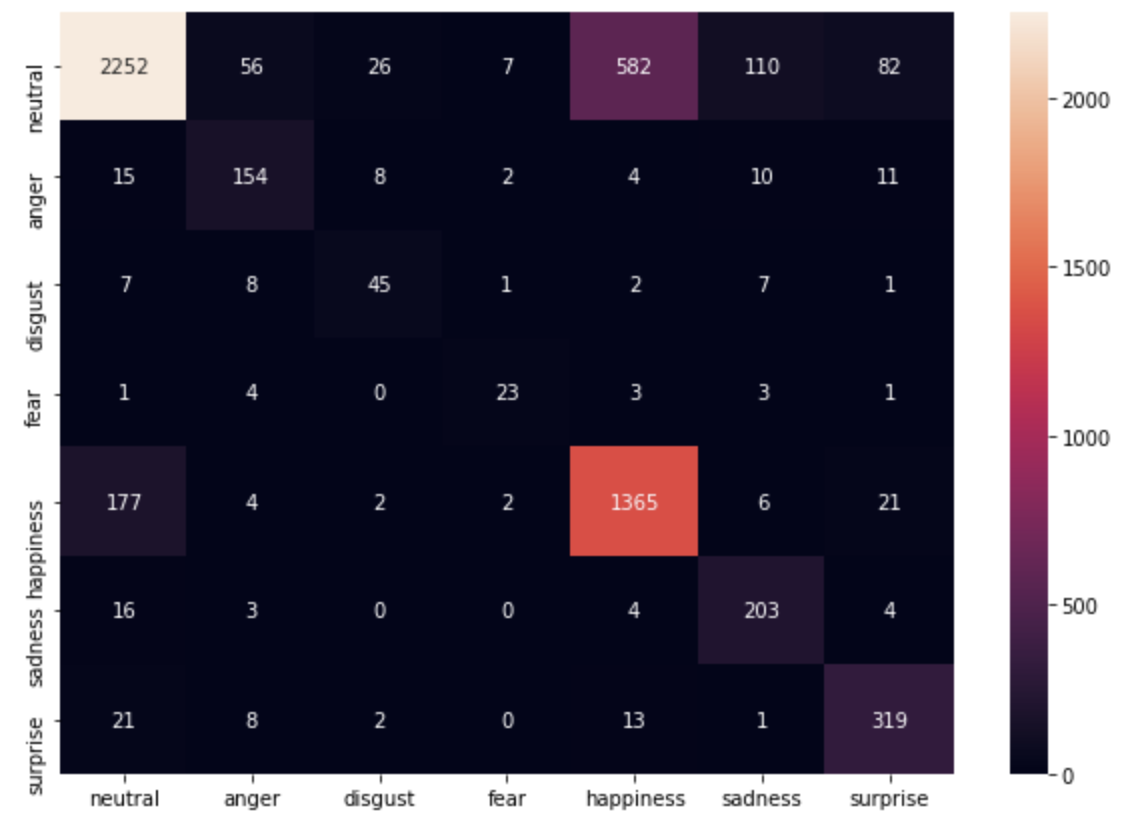

In [8]:
# The table was generated by running the above cell in the process of fine-tuning the model.
Image(filename='../../data/BERT_plots/bert_7_confusion.png', width = 450) 

In [ ]:
# Get predictor from the model ad save it for future use.
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.get_classes()

predictor.save('../../trained_models/bert_model_final_7')

In [ ]:
# Get Amazon data and prepare the dataframe.
amazon = pd.read_csv('../../data/preprocessed/amazon.csv')

In [ ]:
amazon['PREDICTION'] = 0
amazon['neutral'] = 0
amazon['anger'] = 0
amazon['disgust'] = 0
amazon['fear'] = 0
amazon['happiness'] = 0
amazon['sadness'] = 0
amazon['surprise'] = 0

In [ ]:
# Make predictions on Amazon data and store results and probabilities.
for i in range(len(amazon['REVIEW_TEXT'])):
    if i%1000 == 0:
        print('processing', i, ' of', len(amazon))
    out = predictor.predict(amazon['REVIEW_TEXT'][i], return_proba=True)
    amazon.iloc[i, amazon.columns.get_loc('neutral')] = out[0]
    amazon.iloc[i, amazon.columns.get_loc('anger')] = out[1]
    amazon.iloc[i, amazon.columns.get_loc('disgust')] = out[2]
    amazon.iloc[i, amazon.columns.get_loc('fear')] = out[3]
    amazon.iloc[i, amazon.columns.get_loc('happiness')] = out[4]
    amazon.iloc[i, amazon.columns.get_loc('sadness')] = out[5]
    amazon.iloc[i, amazon.columns.get_loc('surprise')] = out[6]
    amazon.iloc[i, amazon.columns.get_loc('PREDICTION')] = predictor.get_classes()[np.argmax(out)]

In [ ]:
# Save results.
amazon.to_csv('../../data/results/amazon_bert7.csv', index=False)